In [2]:
!pip install catboost

import os
import time

import boto3
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sagemaker

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sagemaker.feature_store.feature_group import FeatureGroup
from sklearn.metrics import (
    balanced_accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

RANDOM_STATE = 42

**Data Loading**

In [3]:
path = "star_classification.csv"
df = pd.read_csv(path)

TRAIN_CSV = "data/splits/train.csv"
TEST_CSV = "data/splits/test.csv"
PROD_CSV = "data/splits/prod_monitor.csv"

df_train_full = pd.read_csv(TRAIN_CSV)
df_test_full = pd.read_csv(TEST_CSV)
df_prod_full = pd.read_csv(PROD_CSV)

print("Shapes:")
print("  train:", df_train_full.shape)
print("  test: ", df_test_full.shape)
print("  prod: ", df_prod_full.shape)

Shapes:
  train: (48000, 18)
  test:  (12000, 18)
  prod:  (40000, 18)


In [4]:
df_train_full.head()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237679e+18,25.485966,1.212390,23.10159,22.47028,22.06009,21.64989,20.73721,7717,301,1,500,1.057684e+19,GALAXY,0.819801,9394,58108,498
1,1.237666e+18,56.508320,-0.149718,21.31572,19.14751,18.05425,17.63888,17.40270,4849,301,3,832,8.253977e+18,STAR,-0.000032,7331,56658,16
2,1.237680e+18,31.198037,27.823123,26.08982,22.84966,21.34484,20.06918,19.43591,8097,301,5,56,7.061789e+18,GALAXY,0.676940,6272,56325,527
3,1.237679e+18,20.324498,-5.068324,25.02163,22.93516,21.53009,20.19422,19.55094,7881,301,3,157,8.910385e+18,GALAXY,0.619067,7914,57331,47
4,1.237651e+18,169.956757,64.444565,23.45566,22.37246,20.80178,19.54419,19.01237,1302,301,4,333,8.005202e+18,GALAXY,0.628852,7110,56746,193


In [5]:
df_test_full.head()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237679e+18,32.523988,-2.172826,20.77418,20.16409,20.22348,20.15612,20.01043,7780,301,4,119,8.824826e+18,QSO,0.675220,7838,56958,80
1,1.237661e+18,126.689916,28.463395,19.49815,19.45735,19.18386,19.21205,19.33575,3560,301,5,130,1.199875e+19,QSO,1.162591,10657,58157,114
2,1.237666e+18,220.935430,20.146671,22.85760,21.72209,20.13179,19.11012,18.57593,4678,301,2,130,6.647349e+18,GALAXY,0.511020,5904,56046,131
3,1.237661e+18,134.000719,55.395833,25.32346,22.98458,21.82933,20.72315,19.50044,3600,301,1,25,8.195529e+18,GALAXY,0.836657,7279,57071,377
4,1.237656e+18,226.156222,-1.322290,26.06676,23.07075,21.38233,19.94921,19.36131,2379,301,5,113,4.522878e+18,GALAXY,0.688401,4017,55329,503


In [6]:
df_prod_full.head()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237655e+18,146.835937,52.477005,20.39023,19.26067,19.24129,19.31843,19.34992,2137,301,1,295,2.706670e+18,STAR,-0.000383,2404,53764,24
1,1.237668e+18,234.888718,11.571236,18.89824,17.65536,17.05353,16.70177,16.48362,5326,301,4,231,2.832870e+18,GALAXY,0.087168,2516,54241,386
2,1.237680e+18,21.305254,19.752935,21.49993,22.73646,20.77063,20.54769,19.84928,7923,301,5,315,8.157333e+18,GALAXY,0.572006,7245,56636,683
3,1.237679e+18,9.910134,-5.692226,21.57374,19.92485,19.21845,18.94273,18.82091,7881,301,2,88,8.900396e+18,STAR,-0.000158,7905,57666,572
4,1.237652e+18,216.706752,2.763760,23.27175,21.97507,20.74840,19.96690,20.26157,1458,301,5,613,4.534259e+18,GALAXY,0.445741,4027,55629,947


**Data Exploration**

In [7]:
# class distribution
class_counts = df['class'].value_counts()
class_percentages = df['class'].value_counts(normalize=True) * 100

for name, d in [("train", df_train_full), ("test", df_test_full), ("prod", df_prod_full)]:
    counts = d["class"].value_counts()
    pct = counts / counts.sum() * 100
    print(f"\n{name} class distribution")
    print("-" * 40)
    for cls in counts.index:
        print(f"{cls:10s}: {counts[cls]:6,} ({pct[cls]:.2f}%)")


train class distribution
----------------------------------------
GALAXY    : 28,534 (59.45%)
STAR      : 10,365 (21.59%)
QSO       :  9,101 (18.96%)

test class distribution
----------------------------------------
GALAXY    :  7,133 (59.44%)
STAR      :  2,591 (21.59%)
QSO       :  2,276 (18.97%)

prod class distribution
----------------------------------------
GALAXY    : 23,778 (59.45%)
STAR      :  8,638 (21.59%)
QSO       :  7,584 (18.96%)


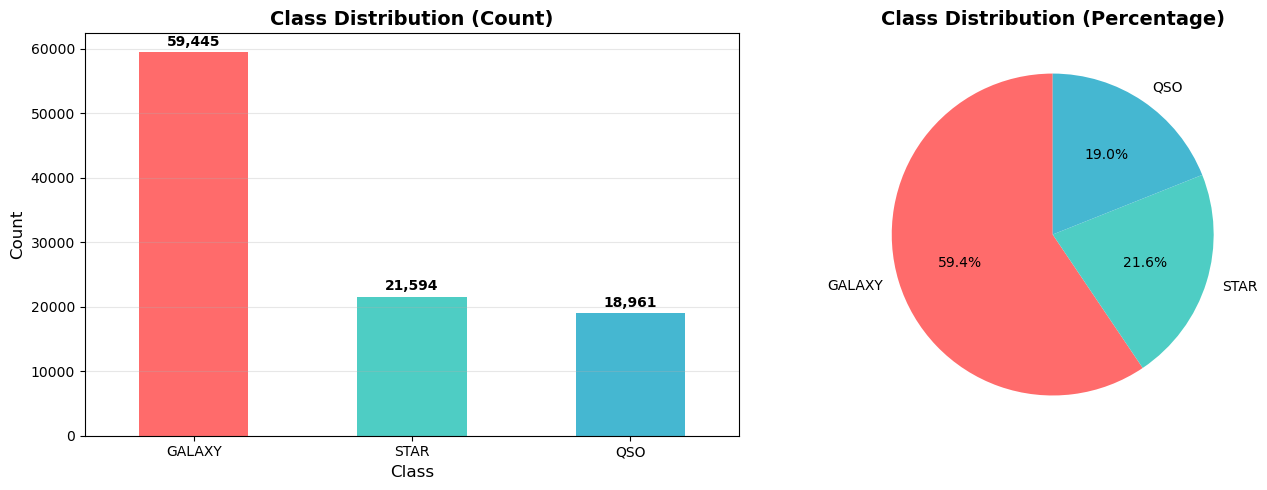

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

class_counts.plot(kind='bar', ax=axes[0], color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
axes[0].set_title('Class Distribution (Count)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Class', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].tick_params(axis='x', rotation=0)
axes[0].grid(axis='y', alpha=0.3)

for i, v in enumerate(class_counts):
    axes[0].text(i, v + 500, f'{v:,}', ha='center', va='bottom', fontweight='bold')

axes[1].pie(class_counts, labels=class_counts.index, autopct='%1.1f%%',
            colors=['#FF6B6B', '#4ECDC4', '#45B7D1'], startangle=90)
axes[1].set_title('Class Distribution (Percentage)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

**S3 Lake Raw Data Storage**

In [9]:
# AWS S3
region = boto3.Session().region_name
boto_session = boto3.Session(region_name=region)
s3 = boto_session.client("s3", region_name=region)
athena = boto_session.client("athena", region_name=region)
sts = boto_session.client("sts", region_name=region)
account_id = sts.get_caller_identity()["Account"]

bucket = f"sagemaker-{region}-{account_id}"
prefix = "sagemaker-featurestore-demo"      

S3_SPLITS = f"s3://{bucket}/{prefix}/splits/"
S3_ATHENA = f"s3://{bucket}/{prefix}/athena_results/"

# Ensure bucket exists
def ensure_bucket(b):
    try:
        s3.head_bucket(Bucket=b)
    except Exception:
        if region == "us-east-1":
            s3.create_bucket(Bucket=b)
        else:
            s3.create_bucket(Bucket=b, CreateBucketConfiguration={"LocationConstraint": region})

ensure_bucket(bucket)

train_key = f"{prefix}/splits/train.csv"
test_key  = f"{prefix}/splits/test.csv"
prod_key  = f"{prefix}/splits/prod_monitor.csv"

s3.upload_file(TRAIN_CSV, bucket, train_key)
s3.upload_file(TEST_CSV,  bucket, test_key)
s3.upload_file(PROD_CSV,  bucket, prod_key)

print("Uploaded:")
print("  TRAIN:", f"s3://{bucket}/{train_key}")
print("  TEST :", f"s3://{bucket}/{test_key}")
print("  PROD :", f"s3://{bucket}/{prod_key}")

# Ensure raw data is in s3

RAW_CSV = "star_classification.csv"
RAW_KEY = f"{prefix}/raw/{os.path.basename(RAW_CSV)}"

s3.upload_file(RAW_CSV, bucket, RAW_KEY)
print("Raw uploaded to:", f"s3://{bucket}/{RAW_KEY}")


Uploaded:
  TRAIN: s3://sagemaker-us-east-1-270118993749/sagemaker-featurestore-demo/splits/train.csv
  TEST : s3://sagemaker-us-east-1-270118993749/sagemaker-featurestore-demo/splits/test.csv
  PROD : s3://sagemaker-us-east-1-270118993749/sagemaker-featurestore-demo/splits/prod_monitor.csv
Raw uploaded to: s3://sagemaker-us-east-1-270118993749/sagemaker-featurestore-demo/raw/star_classification.csv


In [10]:
#  Athena database

DB = "aai540_stellar"
RAW_TBL = "star_classification_raw"
TRAIN_TBL = "star_train"
TEST_TBL  = "star_test"
PROD_TBL  = "star_prod"

S3_RAW = f"s3://{bucket}/{prefix}/raw/"
S3_SPLITS = f"s3://{bucket}/{prefix}/splits/"

def athena_start(sql: str, database: str | None):
    args = {
        "QueryString": sql,
        "ResultConfiguration": {"OutputLocation": S3_ATHENA},
    }
    if database:
        args["QueryExecutionContext"] = {"Database": database}
    return athena.start_query_execution(**args)["QueryExecutionId"]


def athena_wait(qid: str, poll: int = 2):
    while True:
        resp = athena.get_query_execution(QueryExecutionId=qid)
        state = resp["QueryExecution"]["Status"]["State"]

        if state in ("SUCCEEDED", "FAILED", "CANCELLED"):
            if state != "SUCCEEDED":
                reason = resp["QueryExecution"]["Status"].get("StateChangeReason", state)
                raise RuntimeError(f"Athena {state}: {reason}")
            return
        time.sleep(poll)


# database
athena_wait(athena_start(f"CREATE DATABASE IF NOT EXISTS {DB}", database=None))

RAW_SCHEMA = """
  obj_ID BIGINT,
  alpha DOUBLE,
  delta DOUBLE,
  u DOUBLE,
  g DOUBLE,
  r DOUBLE,
  i DOUBLE,
  z DOUBLE,
  run_ID INT,
  rerun_ID INT,
  cam_col INT,
  field_ID INT,
  spec_obj_ID BIGINT,
  class STRING,
  redshift DOUBLE,
  plate INT,
  MJD INT,
  fiber_ID INT
"""

def create_csv_table(table_name: str, location: str, schema: str):
    ddl = f"""
    CREATE EXTERNAL TABLE IF NOT EXISTS {DB}.{table_name} (
    {schema}
    )
    ROW FORMAT SERDE 'org.apache.hadoop.hive.serde2.OpenCSVSerde'
    WITH SERDEPROPERTIES (
      'separatorChar' = ',',
      'quoteChar'     = '\"',
      'escapeChar'    = '\\\\'
    )
    STORED AS TEXTFILE
    LOCATION '{location}'
    TBLPROPERTIES ('skip.header.line.count'='1');
    """
    athena_wait(athena_start(ddl, database=DB))

create_csv_table(RAW_TBL, S3_RAW, RAW_SCHEMA)

def copy_to_folder(src_key: str, folder: str):
    dst_key = f"{prefix}/splits/{folder}/{os.path.basename(src_key)}"
    s3.copy_object(
        Bucket=bucket,
        CopySource={"Bucket": bucket, "Key": src_key},
        Key=dst_key,
    )
    return f"s3://{bucket}/{prefix}/splits/{folder}/"

train_loc = copy_to_folder(train_key, "train")
test_loc  = copy_to_folder(test_key,  "test")
prod_loc  = copy_to_folder(prod_key,  "prod")

create_csv_table(TRAIN_TBL, train_loc, RAW_SCHEMA)
create_csv_table(TEST_TBL,  test_loc,  RAW_SCHEMA)
create_csv_table(PROD_TBL,  prod_loc,  RAW_SCHEMA)

print("Athena tables created:")
print(" ", f"{DB}.{RAW_TBL}")
print(" ", f"{DB}.{TRAIN_TBL}", f"{DB}.{TEST_TBL}", f"{DB}.{PROD_TBL}")


Athena tables created:
  aai540_stellar.star_classification_raw
  aai540_stellar.star_train aai540_stellar.star_test aai540_stellar.star_prod


**Feature Engineering**

In [11]:
def fe_pipeline(df_raw: pd.DataFrame) -> tuple[pd.DataFrame, pd.Series, list[str], list[str]]:
    df2 = df_raw.copy()

    bands = ["u", "g", "r", "i", "z"]
    for c in bands:
        df2[c] = pd.to_numeric(df2[c], errors="coerce")
        df2.loc[df2[c] <= -1000, c] = np.nan

    df2["redshift"] = pd.to_numeric(df2["redshift"], errors="coerce")
    df2.loc[df2["redshift"] < -0.1, "redshift"] = np.nan

    # adjacent colors
    adj_pairs = [("u", "g"), ("g", "r"), ("r", "i"), ("i", "z")]
    for b1, b2 in adj_pairs:
        df2[f"{b1}_{b2}"] = df2[b1] - df2[b2]

    # all other pairwise colors
    adj_set = set(adj_pairs)
    pairwise = []
    for i in range(len(bands)):
        for j in range(i + 1, len(bands)):
            b1, b2 = bands[i], bands[j]
            if (b1, b2) in adj_set:
                continue
            name = f"{b1}_{b2}"
            df2[name] = df2[b1] - df2[b2]
            pairwise.append(name)

    color_feats = [f"{b1}_{b2}" for b1, b2 in adj_pairs] + pairwise

    # summary stats across mags
    df2["mean_mag"] = df2[bands].mean(axis=1)
    df2["mag_std"] = df2[bands].std(axis=1)
    df2["mag_span"] = df2[bands].max(axis=1) - df2[bands].min(axis=1)

    # curvature-like proxies
    df2["curv_ug_gr"] = df2["u_g"] - df2["g_r"]
    df2["curv_gr_ri"] = df2["g_r"] - df2["r_i"]

    eng_numeric = color_feats + ["mean_mag", "mag_std", "mag_span", "curv_ug_gr", "curv_gr_ri"]

    id_like_cols = [
        "obj_ID", "spec_obj_ID", "run_ID", "rerun_ID",
        "cam_col", "field_ID", "plate", "MJD", "fiber_ID",
    ]
    id_like_cols = [c for c in id_like_cols if c in df2.columns]
    for c in id_like_cols:
        df2[c] = df2[c].astype(str).astype("category")

    pos_cols = [c for c in ["alpha", "delta"] if c in df2.columns]

    core_numeric = pos_cols + bands + ["redshift"]
    feature_cols = core_numeric + eng_numeric + id_like_cols
    feature_cols = [c for c in feature_cols if c in df2.columns]

    if len(feature_cols) != len(set(feature_cols)):
        dupes = pd.Series(feature_cols).value_counts()
        raise ValueError(f"Duplicate feature names: {dupes[dupes > 1].to_dict()}")

    required_numeric = core_numeric + eng_numeric
    df2 = df2.dropna(subset=required_numeric + ["class"]).reset_index(drop=True)

    return df2, df2["class"], feature_cols, id_like_cols


In [12]:
#  Apply feature engineering to each split

df_train_fe, y_train_str, feature_cols, id_like_cols = fe_pipeline(df_train_full)
df_test_fe, y_test_str, _, _ = fe_pipeline(df_test_full)
df_prod_fe, y_prod_str, _, _ = fe_pipeline(df_prod_full)

# Align columns to training feature_cols
X_train = df_train_fe[feature_cols].copy()
X_test = df_test_fe[feature_cols].copy()
X_prod = df_prod_fe[feature_cols].copy()

print("Feature matrix shapes:")
print("  X_train:", X_train.shape)
print("  X_test: ", X_test.shape)
print("  X_prod: ", X_prod.shape)

Feature matrix shapes:
  X_train: (47999, 32)
  X_test:  (12000, 32)
  X_prod:  (40000, 32)


In [13]:
# Combine engineered features and write to Feature Store

from datetime import datetime, timezone

# Combine engineered features from all splits and tag with split name
df_all = []
for split_name, df_split_fe in [
    ("train", df_train_fe),
    ("test",  df_test_fe),
    ("prod",  df_prod_fe),
]:
    d = df_split_fe.copy()
    d["split"] = split_name
    df_all.append(d)

df_features_all = pd.concat(df_all, ignore_index=True)

# Add required event_time column for Feature Store
df_features_all["event_time"] = datetime.now(timezone.utc)

print("All features shape:", df_features_all.shape)
df_features_all.head()


All features shape: (99999, 35)


,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,...,g_i,g_z,r_z,mean_mag,mag_std,mag_span,curv_ug_gr,curv_gr_ri,split,event_time
0,1.237678617429017e+18,25.485966,1.212390,23.10159,22.47028,22.06009,21.64989,20.73721,7717,301,...,0.82039,1.73307,1.32288,22.003812,0.888175,2.36438,0.22112,-0.00001,train,2026-02-01 23:15:09.904518+00:00
1,1.2376663005583117e+18,56.508320,-0.149718,21.31572,19.14751,18.05425,17.63888,17.40270,4849,301,...,1.50863,1.74481,0.65155,18.711812,1.602148,3.91302,1.07495,0.67789,train,2026-02-01 23:15:09.904518+00:00
2,1.2376802516349755e+18,31.198037,27.823123,26.08982,22.84966,21.34484,20.06918,19.43591,8097,301,...,2.78048,3.41375,1.90893,21.957882,2.653843,6.65391,1.73534,0.22916,train,2026-02-01 23:15:09.904518+00:00
3,1.2376793228549169e+18,20.324498,-5.068324,25.02163,22.93516,21.53009,20.19422,19.55094,7881,301,...,2.74094,3.38422,1.97915,21.846408,2.200362,5.47069,0.68140,0.06920,train,2026-02-01 23:15:09.904518+00:00
4,1.237651066813482e+18,169.956757,64.444565,23.45566,22.37246,20.80178,19.54419,19.01237,1302,301,...,2.82827,3.36009,1.78941,21.037292,1.871918,4.44329,-0.48748,0.31309,train,2026-02-01 23:15:09.904518+00:00


In [14]:
# Create FeatureGroup and ingest to offline store

from datetime import datetime, timezone
from time import sleep
from sagemaker.session import Session
from sagemaker.feature_store.feature_group import FeatureGroup

sm_session = Session()

feature_group_name = "sdss17_features_fg"
record_identifier_name = "obj_ID"
event_time_name = "event_time"

# 1. Ensure event_time column exists in correct ISO-8601 format
now_str = datetime.now(timezone.utc).strftime("%Y-%m-%dT%H:%M:%SZ")
df_features_all[event_time_name] = now_str  # same timestamp is fine for demo [web:137]

# 2. Create (or attach to) the feature group
fg = FeatureGroup(
    name=feature_group_name,
    sagemaker_session=sm_session,
)

try:
    desc = fg.describe()
    print("Feature group already exists, status:", desc["FeatureGroupStatus"])
except Exception:
    print("Creating feature group...")
    fg.load_feature_definitions(data_frame=df_features_all)
    fg.create(
        s3_uri=f"s3://{bucket}/{prefix}/feature-store/",
        record_identifier_name=record_identifier_name,
        event_time_feature_name=event_time_name,
        role_arn=sm_session.get_caller_identity_arn(),
        enable_online_store=False,
    )

# 3. Best‑effort wait with timeout
max_wait_seconds = 300
start = datetime.now(timezone.utc)

while True:
    desc = fg.describe()
    status = desc["FeatureGroupStatus"]
    print("Current feature group status:", status)

    if status in ("Created", "CreatedNoData", "Active"):
        break

    if status in ("CreateFailed", "Deleting", "Failed"):
        raise RuntimeError(f"Feature group not usable, status={status}")

    if (datetime.now(timezone.utc) - start).total_seconds() > max_wait_seconds:
        print("Timed out waiting for ACTIVE; continuing anyway.")
        break

    sleep(10)

# 4. Ingest data
print("Starting ingest...")
fg.ingest(
    data_frame=df_features_all,
    max_workers=8,
    wait=True,
)
print("Ingest complete.")

Feature group already exists, status: Created
Current feature group status: Created
Starting ingest...
Ingest complete.


In [14]:
#fg.describe()
#fg.describe()["FeatureGroupStatus"]


In [15]:
'''fg.ingest(
    data_frame=df_features_all,
    max_workers=8,
    wait=True,
)
'''

'fg.ingest(\n    data_frame=df_features_all,\n    max_workers=8,\n    wait=True,\n)\n'

In [15]:
# Train/test + validation split

le = LabelEncoder()
y_all = le.fit_transform(y_train_str.astype(str))

X_tr, X_val, y_tr, y_val = train_test_split(
    X_train,
    y_all,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y_all,
)

y_test = le.transform(y_test_str.astype(str))
y_prod = le.transform(y_prod_str.astype(str))

cat_features = [X_train.columns.get_loc(c) for c in id_like_cols]


In [16]:
FE_DIR = "data/features"
os.makedirs(FE_DIR, exist_ok=True)

train_fe_path = os.path.join(FE_DIR, "features_train.csv")
test_fe_path  = os.path.join(FE_DIR, "features_test.csv")
prod_fe_path  = os.path.join(FE_DIR, "features_prod.csv")

# Keep record id + features + label (class). Optionally keep split tag.
def fe_out(df_fe: pd.DataFrame, split_name: str) -> pd.DataFrame:
    out = df_fe[[ "obj_ID" ] + feature_cols + ["class"]].copy()
    out["dataset_split"] = split_name
    return out

fe_out(df_train_fe, "train").to_csv(train_fe_path, index=False)
fe_out(df_test_fe,  "test").to_csv(test_fe_path, index=False)
fe_out(df_prod_fe,  "prod").to_csv(prod_fe_path, index=False)

train_fe_key = f"{prefix}/features/train/features_train.csv"
test_fe_key  = f"{prefix}/features/test/features_test.csv"
prod_fe_key  = f"{prefix}/features/prod/features_prod.csv"

s3.upload_file(train_fe_path, bucket, train_fe_key)
s3.upload_file(test_fe_path,  bucket, test_fe_key)
s3.upload_file(prod_fe_path,  bucket, prod_fe_key)

print("Uploaded engineered features:")
print("  TRAIN:", f"s3://{bucket}/{train_fe_key}")
print("  TEST :", f"s3://{bucket}/{test_fe_key}")
print("  PROD :", f"s3://{bucket}/{prod_fe_key}")

Uploaded engineered features:
  TRAIN: s3://sagemaker-us-east-1-270118993749/sagemaker-featurestore-demo/features/train/features_train.csv
  TEST : s3://sagemaker-us-east-1-270118993749/sagemaker-featurestore-demo/features/test/features_test.csv
  PROD : s3://sagemaker-us-east-1-270118993749/sagemaker-featurestore-demo/features/prod/features_prod.csv


In [17]:
try:
    from sagemaker import get_execution_role
    role_arn = get_execution_role()
except Exception:
    sts = boto3.client("sts")
    role_arn = sts.get_caller_identity()["Arn"]

os.environ["SAGEMAKER_ROLE_ARN"] = str(role_arn)
print("SAGEMAKER_ROLE_ARN:", os.environ["SAGEMAKER_ROLE_ARN"])

SAGEMAKER_ROLE_ARN: arn:aws:iam::270118993749:role/LabRole


**Models(CatBoost + LightGBM)**

In [19]:
cat_model = CatBoostClassifier(
    loss_function="MultiClass",
    iterations=5000,
    learning_rate=0.03,
    depth=8,
    l2_leaf_reg=5.0,
    random_seed=RANDOM_STATE,
    auto_class_weights="Balanced",
    eval_metric="TotalF1",
    allow_writing_files=False,
    verbose=200,
)

cat_model.fit(
    X_tr,
    y_tr,
    cat_features=cat_features,
    eval_set=(X_val, y_val),
    early_stopping_rounds=200,
)


lgbm_model = LGBMClassifier(
    objective="multiclass",
    n_estimators=8000,
    learning_rate=0.02,
    num_leaves=255,
    min_child_samples=30,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1.0,
    class_weight="balanced",
    random_state=RANDOM_STATE,
    verbose=-1,
)

try:
    lgbm_model.fit(
        X_tr,
        y_tr,
        eval_set=[(X_val, y_val)],
        eval_metric="multi_logloss",
        categorical_feature=id_like_cols,
    )
except TypeError:
    lgbm_model.fit(
        X_tr,
        y_tr,
        eval_set=[(X_val, y_val)],
        eval_metric="multi_logloss",
    )

0:	learn: 0.9560252	test: 0.9546363	best: 0.9546363 (0)	total: 369ms	remaining: 30m 45s
200:	learn: 0.9713378	test: 0.9707454	best: 0.9712100 (196)	total: 1m 16s	remaining: 30m 36s
400:	learn: 0.9745823	test: 0.9723034	best: 0.9723034 (396)	total: 2m 46s	remaining: 31m 52s
600:	learn: 0.9772563	test: 0.9721208	best: 0.9725456 (504)	total: 4m 17s	remaining: 31m 23s
800:	learn: 0.9792570	test: 0.9725389	best: 0.9726710 (674)	total: 5m 47s	remaining: 30m 19s
1000:	learn: 0.9810756	test: 0.9730747	best: 0.9732509 (983)	total: 7m 17s	remaining: 29m 8s
1200:	learn: 0.9824759	test: 0.9733685	best: 0.9734857 (1190)	total: 8m 50s	remaining: 27m 56s
1400:	learn: 0.9840058	test: 0.9739116	best: 0.9739702 (1384)	total: 10m 21s	remaining: 26m 37s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.9739701697
bestIteration = 1384

Shrink model to first 1385 iterations.


**Evaluation**

In [20]:
def eval_model(name, model, Xte, yte):
    pred = model.predict(Xte)
    macro = f1_score(yte, pred, average="macro")
    bal = balanced_accuracy_score(yte, pred)
    print(f"\n{name}")
    print("macro_f1:", round(macro, 6))
    print("balanced_acc:", round(bal, 6))
    print(classification_report(yte, pred, target_names=le.classes_, digits=4))
    cm = confusion_matrix(yte, pred)
    print(pd.DataFrame(
        cm,
        index=[f"true_{c}" for c in le.classes_],
        columns=[f"pred_{c}" for c in le.classes_],
    ))
    return macro, bal


In [21]:
cat_scores_test = eval_model(
    "CatBoost (IDs as categorical) – TEST",
    cat_model,
    X_test,
    y_test,
)

lgb_scores_test = eval_model(
    "LightGBM (with IDs) – TEST",
    lgbm_model,
    X_test,
    y_test,
)

print("\nTest scores:")
print("  CatBoost:", cat_scores_test)
print("  LightGBM:", lgb_scores_test)


CatBoost (IDs as categorical) – TEST
macro_f1: 0.972536
balanced_acc: 0.974781
              precision    recall  f1-score   support

      GALAXY     0.9833    0.9760    0.9797      7133
         QSO     0.9437    0.9495    0.9466      2276
        STAR     0.9840    0.9988    0.9914      2591

    accuracy                         0.9759     12000
   macro avg     0.9703    0.9748    0.9725     12000
weighted avg     0.9760    0.9759    0.9759     12000

             pred_GALAXY  pred_QSO  pred_STAR
true_GALAXY         6962       129         42
true_QSO             115      2161          0
true_STAR              3         0       2588

LightGBM (with IDs) – TEST
macro_f1: 0.972633
balanced_acc: 0.970228
              precision    recall  f1-score   support

      GALAXY     0.9768    0.9837    0.9802      7133
         QSO     0.9553    0.9293    0.9421      2276
        STAR     0.9935    0.9977    0.9956      2591

    accuracy                         0.9764     12000
   macro avg 

In [22]:
cat_scores_prod = eval_model(
    "CatBoost – PROD MONITOR",
    cat_model,
    X_prod,
    y_prod,
)

lgb_scores_prod = eval_model(
    "LightGBM – PROD MONITOR",
    lgbm_model,
    X_prod,
    y_prod,
)

print("\nProd-monitor scores:")
print("  CatBoost:", cat_scores_prod)
print("  LightGBM:", lgb_scores_prod)


CatBoost – PROD MONITOR
macro_f1: 0.974078
balanced_acc: 0.976524
              precision    recall  f1-score   support

      GALAXY     0.9849    0.9768    0.9808     23778
         QSO     0.9483    0.9533    0.9508      7584
        STAR     0.9819    0.9994    0.9906      8638

    accuracy                         0.9772     40000
   macro avg     0.9717    0.9765    0.9741     40000
weighted avg     0.9773    0.9772    0.9772     40000

             pred_GALAXY  pred_QSO  pred_STAR
true_GALAXY        23227       394        157
true_QSO             352      7230          2
true_STAR              5         0       8633

LightGBM – PROD MONITOR
macro_f1: 0.974829
balanced_acc: 0.972521
              precision    recall  f1-score   support

      GALAXY     0.9786    0.9852    0.9819     23778
         QSO     0.9599    0.9343    0.9469      7584
        STAR     0.9933    0.9980    0.9957      8638

    accuracy                         0.9783     40000
   macro avg     0.9773    0.

In [23]:
n_total = len(df_train_full) + len(df_test_full) + len(df_prod_full)
print("Total rows:", n_total)

print("Train split (csv): {:.2%}".format(len(df_train_full) / n_total))
print("Test  split (csv): {:.2%}".format(len(df_test_full) / n_total))
print("Prod  split (csv): {:.2%}".format(len(df_prod_full) / n_total))

print("Train internal (X_tr): {:.2%}".format(len(X_tr) / n_total))
print("Val   internal (X_val): {:.2%}".format(len(X_val) / n_total))
print("Test  final (X_test):   {:.2%}".format(len(X_test) / n_total))


Total rows: 100000
Train split (csv): 48.00%
Test  split (csv): 12.00%
Prod  split (csv): 40.00%
Train internal (X_tr): 38.40%
Val   internal (X_val): 9.60%
Test  final (X_test):   12.00%


In [25]:
!jupyter nbconvert --to html "Final_Project_AAI_540_with_data_split.ipynb"


[NbConvertApp] Converting notebook Final_Project_AAI_540_with_data_split.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 1 image(s).
[NbConvertApp] Writing 740701 bytes to Final_Project_AAI_540_with_data_split.html


### Proof Offline Feature Store Works

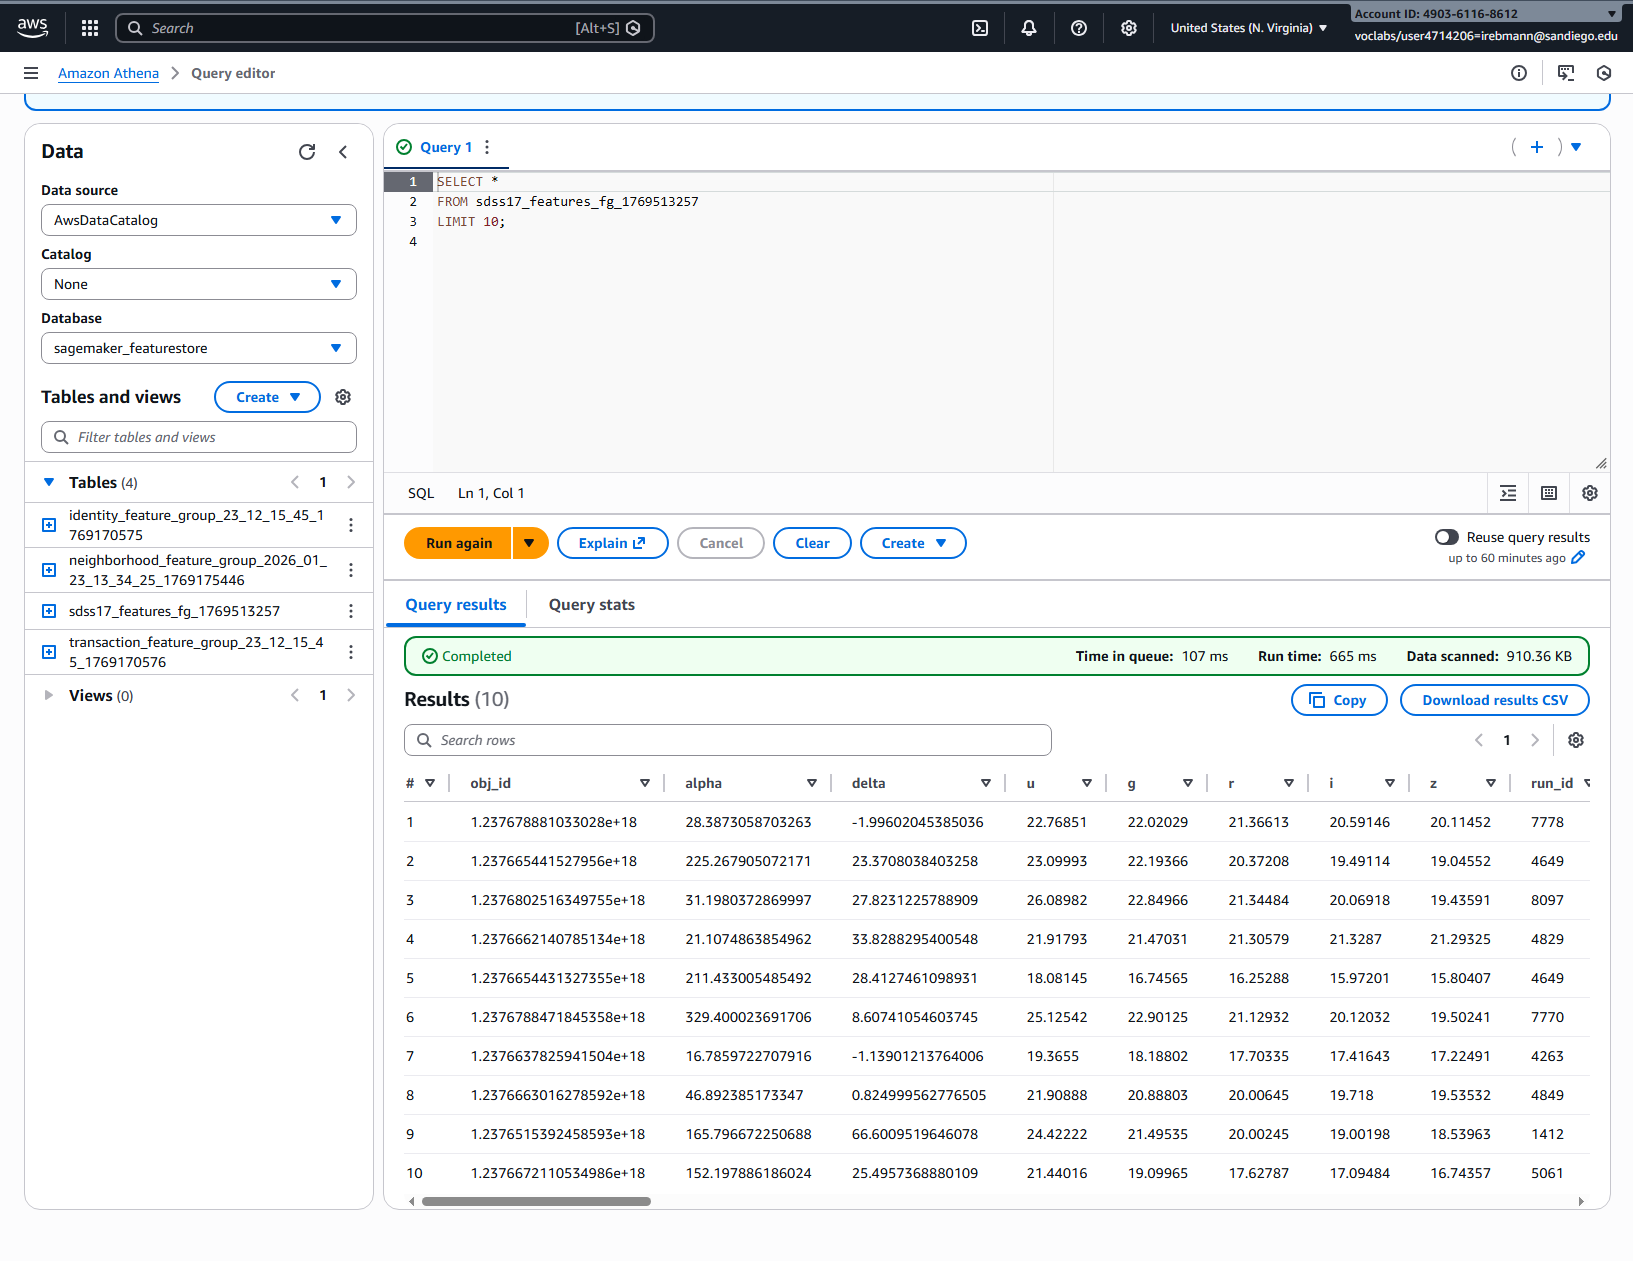

**Model Deployment**

In [20]:
import boto3, sagemaker, pandas as pd, numpy as np, re, json
from io import BytesIO
from time import gmtime, strftime

# preprocess to numeric labels (doesn't work with STAR/QUASAR/GALAXY for some reason)

bucket = "sagemaker-us-east-1-270118993749"
prefix = "sagemaker-featurestore-demo"

sess = sagemaker.Session()
region = sess.boto_region_name
s3 = boto3.client("s3")

train_fe_s3 = f"s3://{bucket}/{prefix}/features/train/features_train.csv"
test_fe_s3  = f"s3://{bucket}/{prefix}/features/test/features_test.csv"
prod_fe_s3  = f"s3://{bucket}/{prefix}/features/prod/features_prod.csv"

LABEL_TO_ID = {
    "GALAXY": 0,
    "STAR": 1,
    "QSO": 2,
}
ID_TO_LABEL = {0: "GALAXY", 1: "STAR", 2: "QSO"}

def _parse_s3(s3uri: str):
    m = re.match(r"s3://([^/]+)/(.*)", s3uri)
    if not m:
        raise ValueError(f"Bad s3 uri: {s3uri}")
    return m.group(1), m.group(2)

def _read_csv_s3(s3uri: str) -> pd.DataFrame:
    b, k = _parse_s3(s3uri)
    obj = s3.get_object(Bucket=b, Key=k)
    return pd.read_csv(BytesIO(obj["Body"].read()))

def _put_bytes_s3(data: bytes, s3uri: str, content_type="text/csv"):
    b, k = _parse_s3(s3uri)
    s3.put_object(Bucket=b, Key=k, Body=data, ContentType=content_type)

def build_numeric_feature_list(df: pd.DataFrame) -> list[str]:
    drop_cols = {"class", "obj_ID", "dataset_split", "split", "event_time"}
    feat_cols = [c for c in df.columns if c not in drop_cols]
    X = df[feat_cols].copy()

    Xn = X.apply(pd.to_numeric, errors="coerce")
    keep = [c for c in Xn.columns if not Xn[c].isna().all()]
    return keep

def make_xgb_train_csv(s3_in_with_header: str, s3_out_no_header: str, feature_cols: list[str]) -> str:
    df = _read_csv_s3(s3_in_with_header)

    y_raw = df["class"].astype(str).str.strip().str.upper()
    y = y_raw.map(LABEL_TO_ID)

    if y.isna().any():
        bad = sorted(y_raw[y.isna()].unique().tolist())
        raise ValueError(f"Unmapped labels in 'class': {bad}. Update LABEL_TO_ID.")

    X = df.reindex(columns=feature_cols).copy()
    X = X.apply(pd.to_numeric, errors="coerce").fillna(0.0)

    out = pd.concat([y.astype(int).rename("label"), X], axis=1)
    _put_bytes_s3(out.to_csv(index=False, header=False).encode("utf-8"), s3_out_no_header)
    return s3_out_no_header

def make_xgb_features_csv(s3_in_with_header: str, s3_out_no_header: str, feature_cols: list[str]) -> str:
    df = _read_csv_s3(s3_in_with_header)
    X = df.reindex(columns=feature_cols).copy()
    X = X.apply(pd.to_numeric, errors="coerce").fillna(0.0)
    _put_bytes_s3(X.to_csv(index=False, header=False).encode("utf-8"), s3_out_no_header)
    return s3_out_no_header

df_train = _read_csv_s3(train_fe_s3)
feature_cols = build_numeric_feature_list(df_train)
print("Numeric feature count:", len(feature_cols))

features_json_s3 = f"s3://{bucket}/{prefix}/prepared/features_columns.json"
_put_bytes_s3(json.dumps(feature_cols).encode("utf-8"), features_json_s3, content_type="application/json")
print("Saved feature columns to:", features_json_s3)

job_name = "xgb-fe-" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())

train_xgb_s3 = f"s3://{bucket}/{prefix}/prepared/{job_name}/train.csv"
val_xgb_s3   = f"s3://{bucket}/{prefix}/prepared/{job_name}/validation.csv"

test_X_s3  = f"s3://{bucket}/{prefix}/prepared/{job_name}/test_features.csv"
prod_X_s3  = f"s3://{bucket}/{prefix}/prepared/{job_name}/prod_features.csv"

make_xgb_train_csv(train_fe_s3, train_xgb_s3, feature_cols)
make_xgb_train_csv(test_fe_s3,  val_xgb_s3,   feature_cols)

make_xgb_features_csv(test_fe_s3, test_X_s3, feature_cols)
make_xgb_features_csv(prod_fe_s3, prod_X_s3, feature_cols)

print("Prepared:")
print("  train:", train_xgb_s3)
print("  val:  ", val_xgb_s3)
print("  testX:", test_X_s3)
print("  prodX:", prod_X_s3)


Numeric feature count: 32
Saved feature columns to: s3://sagemaker-us-east-1-270118993749/sagemaker-featurestore-demo/prepared/features_columns.json
Prepared:
  train: s3://sagemaker-us-east-1-270118993749/sagemaker-featurestore-demo/prepared/xgb-fe-2026-02-01-23-26-04/train.csv
  val:   s3://sagemaker-us-east-1-270118993749/sagemaker-featurestore-demo/prepared/xgb-fe-2026-02-01-23-26-04/validation.csv
  testX: s3://sagemaker-us-east-1-270118993749/sagemaker-featurestore-demo/prepared/xgb-fe-2026-02-01-23-26-04/test_features.csv
  prodX: s3://sagemaker-us-east-1-270118993749/sagemaker-featurestore-demo/prepared/xgb-fe-2026-02-01-23-26-04/prod_features.csv


In [21]:
import boto3, sagemaker
from time import gmtime, strftime


# Deploy Model

try:
    role = sagemaker.get_execution_role()
except Exception:
    role = boto3.client("iam").get_role(RoleName="LabRole")["Role"]["Arn"]

image = sagemaker.image_uris.retrieve("xgboost", region=region, version="1.7-1")

job_name = "xgb-train-" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
output_location = f"s3://{bucket}/{prefix}/output/{job_name}"

est = sagemaker.estimator.Estimator(
    image_uri=image,
    role=role,
    instance_count=1,
    instance_type="ml.m5.xlarge",
    volume_size=50,
    input_mode="File",
    output_path=output_location,
    sagemaker_session=sess,
)

est.set_hyperparameters(
    objective="multi:softprob",
    num_class=3,
    max_depth=5,
    eta=0.2,
    subsample=0.8,
    verbosity=0,
    num_round=200,
)

train_data = sagemaker.inputs.TrainingInput(train_xgb_s3, content_type="text/csv")
val_data   = sagemaker.inputs.TrainingInput(val_xgb_s3,   content_type="text/csv")

est.fit({"train": train_data, "validation": val_data}, job_name=job_name, logs=True)

print("TRAINING_JOB:", job_name)
print("ID_TO_LABEL:", {0:"GALAXY", 1:"STAR", 2:"QSO"})


INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.telemetry.telemetry_logging:SageMaker Python SDK will collect telemetry to help us better understand our user's needs, diagnose issues, and deliver additional features.
To opt out of telemetry, please disable via TelemetryOptOut parameter in SDK defaults config. For more information, refer to https://sagemaker.readthedocs.io/en/stable/overview.html#configuring-and-using-defaults-with-the-sagemaker-python-sdk.
INFO:sagemaker:Creating training-job with name: xgb-train-2026-02-01-23-26-17


2026-02-01 23:26:19 Starting - Starting the training job...
2026-02-01 23:26:33 Starting - Preparing the instances for training...
2026-02-01 23:27:21 Downloading - Downloading the training image......
2026-02-01 23:28:11 Training - Training image download completed. Training in progress../miniconda3/lib/python3.9/site-packages/sagemaker_containers/_server.py:22: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
[2026-02-01 23:28:18.465 ip-10-2-84-9.ec2.internal:7 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2026-02-01 23:28:18.527 ip-10-2-84-9.ec2.internal:7 INFO profiler_config_parser.py:111] User has disabled profiler.
[2026-02-01:23:28:18:INFO] Imported framework sagemaker_xgboost_container.training
[2026-02-01:23:28:18:INFO] Failed to parse hyperparameter obje

In [22]:
from sagemaker.transformer import Transformer
from time import gmtime, strftime

bt_name = "xgb-batch-" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
bt_out  = f"s3://{bucket}/{prefix}/batch-output/{bt_name}/"

transformer = est.transformer(
    instance_count=1,
    instance_type="ml.m5.xlarge",
    output_path=bt_out,
    assemble_with="Line",
    accept="text/csv",
)

transformer.transform(
    data=test_X_s3,
    content_type="text/csv",
    split_type="Line",
)

transformer.wait()
print("Batch output:", bt_out)


INFO:sagemaker:Creating model with name: sagemaker-xgboost-2026-02-01-23-31-25-496
INFO:sagemaker:Creating transform job with name: sagemaker-xgboost-2026-02-01-23-31-26-425


................................/miniconda3/lib/python3.9/site-packages/sagemaker_containers/_server.py:22: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
[2026-02-01:23:36:48:INFO] No GPUs detected (normal if no gpus installed)
[2026-02-01:23:36:48:INFO] No GPUs detected (normal if no gpus installed)
[2026-02-01:23:36:48:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
    client_max_body_size 0;
    keepalive_timeout 3;
    location ~ ^/(ping|in

In [26]:
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import StringDeserializer
import numpy as np
import pandas as pd
import json, re
from io import BytesIO

# Endpoint
endpoint_name = "xgb-ep-" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
predictor = est.deploy(
    initial_instance_count=1,
    instance_type="ml.m5.xlarge",
    endpoint_name=endpoint_name,
)

predictor.serializer = CSVSerializer()
predictor.deserializer = StringDeserializer()

b, k = _parse_s3(features_json_s3)
feature_cols = json.loads(s3.get_object(Bucket=b, Key=k)["Body"].read())


INFO:sagemaker:Creating model with name: sagemaker-xgboost-2026-02-01-23-59-27-853
INFO:sagemaker:Creating endpoint-config with name xgb-ep-2026-02-01-23-59-27
INFO:sagemaker:Creating endpoint with name xgb-ep-2026-02-01-23-59-27


------!

In [27]:
import json
import numpy as np

resp = predictor.predict(payload)

if isinstance(resp, (bytes, bytearray)):
    resp = resp.decode("utf-8")

data = json.loads(resp) if isinstance(resp, str) else resp

scores = data["predictions"][0].get("score", data["predictions"][0].get("scores"))
probs = np.array(scores, dtype=float)

pred_id = int(probs.argmax())
print("probs:", probs, "pred_id:", pred_id, "pred_label:", ID_TO_LABEL[pred_id])


probs: [2.80541647e-03 1.88240992e-05 9.97175694e-01] pred_id: 2 pred_label: QSO


In [42]:
sm = boto3.client("sagemaker")

resp = sm.list_endpoints(MaxResults=100)
for ep in resp["Endpoints"]:
    print(f'{ep["EndpointName"]}  |  {ep["EndpointStatus"]}')

#  Delete all endpoints
for ep in resp["Endpoints"]:
    name = ep["EndpointName"]
    try:
        sm.delete_endpoint(EndpointName=name)
        print(f"Delete requested: {name}")
    except Exception as e:
        print(f"Skip: {name}  ({e})")
